# [Exploration 05] Spectrogram Classification
- 2차원의 spectrogram 데이터를 분류하는 task
- 기본 모델과 skip connection을 사용한 모델로 나누어 성능을 비교한다. 
- data source : [Kaggle/TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)

# 1-dimension wav file classification
spectrogram 데이터를 다루기 전(변환 전) wav 파일을 이용해서 분류해보겠다.(데이터 간의 성능비교를 위해)
## 1. load data 

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print(speech_data)
print(speech_data.keys())
print(speech_data.values())

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f81e630edd0>)
ValuesView(<numpy.lib.npyio.NpzFile object at 0x7f81e630edd0>)


- speech_data는 wav_vals, label_vals로 이루어져있다.

In [2]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [3]:
print(speech_data["wav_vals"][0])
print(len(speech_data["wav_vals"][0]))
print(speech_data["label_vals"])

[-1.27418665e-04 -1.12644804e-04 -1.86756923e-04 ... -1.62762426e-05
 -4.93293861e-04 -3.55132594e-04]
8000
[['down']
 ['down']
 ['down']
 ...
 ['silence']
 ['silence']
 ['silence']]


- data는 총 50,620개
- 모두 1초 음성데이터이다. 
- sampling rate : 8,000   


- data 확인

In [4]:
import IPython.display as ipd
import random

rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # sampling rate : 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  22829
Wave data shape :  (8000,)
label :  ['down']


## 2. data 전처리
- text로 된 label data 처리 
- split data set    



- label data 확인

In [5]:
labels = speech_data["label_vals"]
np.unique(labels)

array(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence',
       'stop', 'unknown', 'up', 'yes'], dtype='<U7')

- 'unkown', 'silence'를 추가한다.
- 각 label에 인덱스를 부여한다.

In [6]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


- 위에서 만들어 둔 index를 이용해 label data를 숫자(index)로 바꾼다. 

In [7]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

- data split : sklearn.model_selection을 이용한다. 

In [8]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
#print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # CNN모델에 넣기 위해 차원을 늘려준다. 
test_wav = test_wav.reshape([-1, sr, 1])

print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)


## 3. data setting
- tf.data.Dataset 을 이용해 데이터셋을 구성한다. 
- 데이터셋 전처리, 배치처리를 쉽게할 수 있는 패키지

In [9]:
# one hot encoding 해주는 함수
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

### hyper parameter 조정 

In [10]:
batch_size = 32
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj26/aiffel/speech_recognition/models/wav'

In [11]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
# map함수를 사용하면, 함수를 매핑할 수 있다.
train_dataset = train_dataset.map(one_hot_label)
# repeat() : data를 반복호출한다.
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


## 4. wave classification 모델 구현 
- 1차원으로 구성한 데이터를 분류할 수 있는 CNN 모델을 구축한다.

In [12]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

In [13]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

- 가장 성능이 좋은 모델을 checkpoint directory에 저장한다.

In [14]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [15]:
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/5
1423/1423 [==============================] - ETA: 0s - loss: 1.3899 - accuracy: 0.5404
Epoch 00001: val_loss improved from inf to 1.07408, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 160s 113ms/step - loss: 1.3899 - accuracy: 0.5404 - val_loss: 1.0741 - val_accuracy: 0.6347
Epoch 2/5
1423/1423 [==============================] - ETA: 0s - loss: 0.8650 - accuracy: 0.7303
Epoch 00002: val_loss improved from 1.07408 to 0.77658, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 162s 114ms/step - loss: 0.8650 - accuracy: 0.7303 - val_loss: 0.7766 - val_accuracy: 0.7496
Epoch 3/5
1423/1423 [==============================] - ETA: 0s - loss: 0.6309 - accuracy: 0.8083
Epoch 00003: val_loss improved from 0.77658 to 0.55744, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 162s 114ms/st

## 5. visualize model training history

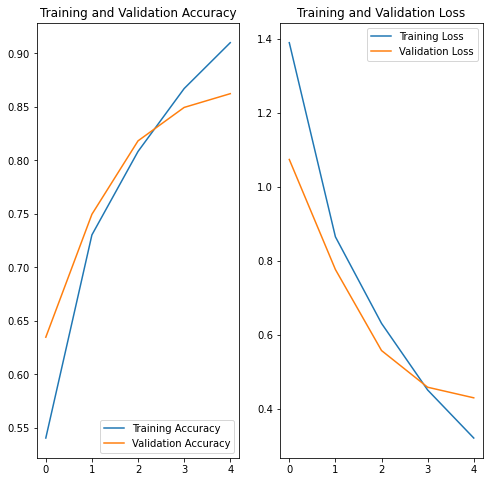

In [16]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. evaluate with best model weights

In [17]:
model_wav.load_weights(checkpoint_dir)
results_wav = model_wav.evaluate(test_dataset)
print(results_wav)

159/159 [==============================] - 12s 78ms/step - loss: 0.4294 - accuracy: 0.8625
[0.4293529689311981, 0.8625049591064453]


In [18]:
# loss
print("loss value: {:.3f}".format(results_wav[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results_wav[1]*100))

loss value: 0.429
accuracy value: 86.2505%


## 7. test model
- 음성 파일을 확인해 예측한 결과를 확인한다.

In [19]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  silence


In [20]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: silence(Correct!)


In [21]:
del speech_data
del label_data

# spectrogram classification
- 1차원의 데이터를 spectrogram으로 변환한다. 

## 1. data 전처리
- data를 가져온다. 위 코드에서 사용한 데이터를 사용한다. 

In [2]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print(speech_data)
print(speech_data.keys())
print(speech_data.values())
print(type(speech_data['wav_vals'][0]))

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f4af823d750>)
ValuesView(<numpy.lib.npyio.NpzFile object at 0x7f4af823d750>)
<class 'numpy.ndarray'>


In [3]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [4]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

## 2. data setting
- wav 파일을 spectrogram으로 변환한다.
- train, validation으로 나눈다.
- tf.data.Dataset 을 이용해 데이터셋을 구성한다. 
- 데이터셋 전처리, 배치처리를 쉽게할 수 있는 패키지

In [5]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [6]:
print(type(speech_data["wav_vals"]))
print(speech_data["wav_vals"][0].shape)
print(speech_data["wav_vals"].shape)

<class 'numpy.ndarray'>
(8000,)
(50620, 8000)


In [7]:
spec_data=[]
for wav in speech_data["wav_vals"]:
    temp = wav2spec(wav)
    spec_data.append(temp)
    
spec_data=np.array(spec_data)

print(spec_data.shape)

(50620, 130, 126)


- map함수를 통해 spectrogram으로 변환하는 코드

In [8]:
# spec_data = np.ndarray(shape=(50620, 8000), dtype=float)
# spec_data= np.append(spec_data,tf.numpy_function(wav2spec, wav, tf.float32))

In [9]:
# spec_data = speech_data["wav_vals"].map(wav2spec)

In [10]:
from sklearn.model_selection import train_test_split

sr = 8000
train_spec, test_spec, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

print("train data : ", train_spec.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spec.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 130, 126)
train labels :  (45558,)
test data :  (5062, 130, 126)
test labels :  (5062,)


In [11]:
len_train_spec = len(train_spec)
len_test_spec = len(test_spec)

- spectrogram 확인 

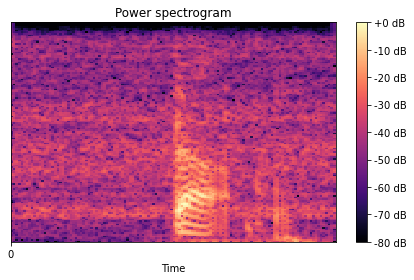

In [12]:
import librosa.display
import matplotlib.pyplot as plt

librosa.display.specshow(librosa.amplitude_to_db(train_spec[0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [13]:
del spec_data
del speech_data
del label_data

### hyper parameter 조정 

In [14]:
batch_size = 32
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

checkpoint_dir

'/home/aiffel-dj26/aiffel/speech_recognition/models/spec'

In [15]:
# one hot encoding 해주는 함수
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [16]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


In [17]:
del train_spec
del test_spec
del train_label
del test_label

## 3. spec classification 모델 구현 
- 2차원으로 구성한 데이터를 분류할 수 있는 CNN 모델을 구축한다.
- wav classification 모델과 동일한 모델(conv 1d)로 성능을 비교한다. 

In [18]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

In [22]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [37]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [24]:
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch= len_train_spec // batch_size,
                    validation_data=test_dataset,
                    validation_steps= len_test_spec // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/5
1419/1423 [============================>.] - ETA: 0s - loss: 1.3872 - accuracy: 0.5263
Epoch 00001: val_loss improved from inf to 0.97629, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 10s 7ms/step - loss: 1.3863 - accuracy: 0.5266 - val_loss: 0.9763 - val_accuracy: 0.6665
Epoch 2/5
1419/1423 [============================>.] - ETA: 0s - loss: 0.6505 - accuracy: 0.7841
Epoch 00002: val_loss improved from 0.97629 to 0.51203, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 10s 7ms/step - loss: 0.6507 - accuracy: 0.7841 - val_loss: 0.5120 - val_accuracy: 0.8208
Epoch 3/5
1423/1423 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.8529
Epoch 00003: val_loss improved from 0.51203 to 0.45751, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 10s 7ms/step - l

## 4. visualize model training history

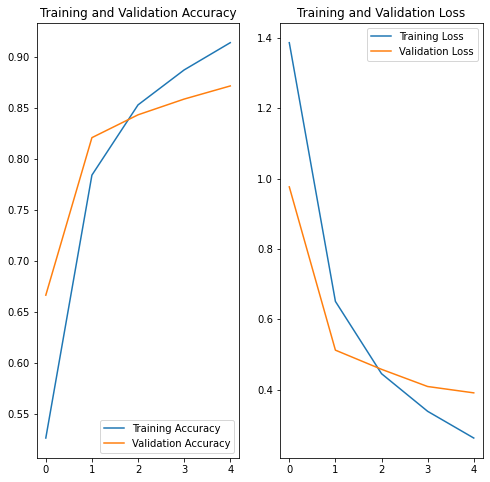

In [25]:
acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 5. evaluate with best model weights

In [26]:
model_spec.load_weights(checkpoint_dir)
results_spec = model_spec.evaluate(test_dataset)
print(results_spec)

159/159 [==============================] - 20s 129ms/step - loss: 0.3903 - accuracy: 0.8716
[0.39028048515319824, 0.8715922832489014]


In [27]:
# loss
print("loss value: {:.3f}".format(results_spec[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results_spec[1]*100))

loss value: 0.390
accuracy value: 87.1592%


### 성능 비교 (wav vs spec)
- wav : 86.2505%
- spectrogram : 87.1592%


## 7. test model
- 음성 파일을 확인해 예측한 결과를 확인한다.
- 메모리가 많이 쌓여 확인할 수 없었다. 

In [27]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len_test_spec, size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

NameError: name 'test_spec' is not defined

In [ ]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

## 8. skip connection 을 추가한 모델의 성능 확인 

In [30]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 130, 32)      36320       input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 130, 32)      9248        conv1d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_8 (MaxPooling1D)  (None, 65, 32)       0           conv1d_21[0][0]                  
____________________________________________________________________________________________

In [31]:
batch_size = 32
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_skip'

checkpoint_dir

'/home/aiffel-dj26/aiffel/speech_recognition/models/spec_skip'

In [32]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [38]:
history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch= 45558 // batch_size,
                    validation_data=test_dataset,
                    validation_steps= 5062 // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/5
1416/1423 [============================>.] - ETA: 0s - loss: 0.2258 - accuracy: 0.9264
Epoch 00001: val_loss improved from inf to 0.30553, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 11s 8ms/step - loss: 0.2258 - accuracy: 0.9264 - val_loss: 0.3055 - val_accuracy: 0.8975
Epoch 2/5
1423/1423 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.9389
Epoch 00002: val_loss improved from 0.30553 to 0.29923, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 11s 8ms/step - loss: 0.1865 - accuracy: 0.9389 - val_loss: 0.2992 - val_accuracy: 0.9015
Epoch 3/5
1419/1423 [============================>.] - ETA: 0s - loss: 0.1596 - accuracy: 0.9475
Epoch 00003: val_loss improved from 0.29923 to 0.27770, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 1

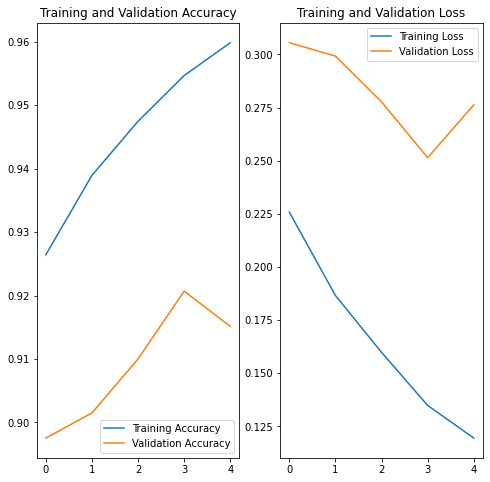

In [39]:
acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
model_spec_skip.load_weights(checkpoint_dir)
results_spec_skip = model_spec_skip.evaluate(test_dataset)
print(results_spec_skip)

159/159 [==============================] - 5s 34ms/step - loss: 0.2511 - accuracy: 0.9208
[0.2511307895183563, 0.9207823276519775]


In [41]:
# loss
print("loss value: {:.3f}".format(results_spec_skip[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results_spec_skip[1]*100))

loss value: 0.251
accuracy value: 92.0782%


## 성능 비교
- **wav** vs **spectrogram** vs **skip-connection**
- wav : 86.2505%
- spectrogram : 87.1592%
- skip-connection : 92.0782%

In [ ]:
print("wav data accuracy value: {:.4f}%".format(results_wav[1]*100))
print("spectrogram data accuracy value: {:.4f}%".format(results_spec[1]*100))
print("skip-connection accuracy value: {:.4f}%".format(results_spec_skip[1]*100))

# 정리
---
1. 캐글 wav 파일을 로드한다. 
    - shpae, data type을 확인한다.
    - ipd.Audio() 을 사용해 레이블과 데이터를 확인한다. 
2. 데이터 전처리  
    - label에 'unknown', 'silence'를 추가하고 숫자 형태로 바꾼다.
    - train, test 로 나눈다. 
3. spectrogram 변환
    - wav 파일을 spectrogram으로 변환한다.
4. dataset을 구성한다.
    - tf.dataset을 이용해, data와 label을 합쳐 dataset을 구성한다. 
5. classification 모델 구성
    - 각 파일의 차원에 주의하며 모델을 구성한다. 
6. 모델 성능 평가
    - 시각화를 통해 과적합여부를 판단하며 파라미터를 조정한다.
    - 제일 성능이 좋은 모델을 저장해 평가에 사용한다. 
    - 음성을 직접 들어 예측 결과를 확인한다.


# 루브릭 평가
---
1. **음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.**   
    - 스펙토그램을 출력해 확인하고, shape을 확인했다.

    
2. **1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.**  
    - wav 데이터와 spectrogram 데이터의 성능을 비교했다.
    - 성능(accuracy)은 wav: 86.2505%  , spectrogram: 87.1592%로 spectrogram이 더 좋은 성능을 보였다.
    
    
3. **테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.**  
    - wav, spectrogram, skip connection을 사용한 세 모델 전부 accuracy가 75%를 넘었다. 
    - spectrogram 데이터를 skip connection을 추가한 모델의 성능이 가장 좋았다. (accuracy 90% 이상)

    
# 회고
---
## 더 공부하고 싶은 부분
- ndarry를 map으로 함수를 적용하는 부분 : 에러를 해결해 for문없이 코드를 구성하고 싶다.
- audio data : 정확히 어떻게 구성되어있는지, 데이터에 대한 공부를 하고 싶다.
- tensor : tensor에 대한 타입에러가 종종 발생하는데 더 깊게 공부하면 좋을 것 같다. 
- tensorflow graph, eager : tensorflow가 동작하는 방법에 대한 부분 
## 느낀 점
오디오 데이터처럼 특정 데이터를 다루기 위해서는 그 데이터에 대한 깊은 공부가 필요하다는 생각이 들었다. 오디오를 분류하는 모델이 재미있었지만 더 공부한다면 모델을 구성할 때 더 데이터에 맞게 구성할 수 있을 것 같다. 